In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig
import re
import random
import numpy as np
import traceback
import warnings
import matplotlib.pyplot as plt
from src.utils import format_data
warnings.filterwarnings('ignore')

/ext3/miniconda3/envs/inference/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pretrained = "meta-llama/Llama-3.1-8B-Instruct"
model = AutoModelForCausalLM.from_pretrained(pretrained, output_attentions=True).cuda()
tokenizer = AutoTokenizer.from_pretrained(pretrained)

Loading checkpoint shards: 100%|██████████| 4/4 [00:18<00:00,  4.67s/it]


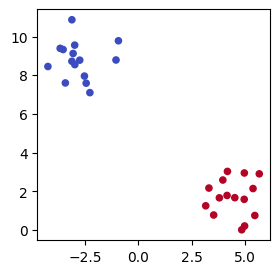

In [3]:
from sklearn.datasets import make_blobs
points, gt = make_blobs(n_samples=30, centers=2, n_features=2, random_state=42)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.scatter(points[:,0], points[:,1], c=gt, s=20, cmap='coolwarm')
plt.show()

In [4]:
sys_prompt = 'You are a data clustering expert.'
messages = format_data(points, sys_prompt, n_clusters=2)
messages

[{'role': 'system', 'content': 'You are a data clustering expert.'},
 {'role': 'human',
  'content': 'Cluster the following data into 2 clusters. Only output the cluster labels for each point as a list of integers. No code. Data: \n[[ -0.93, 9.78], [ 4.85, 0.01], [ -4.23, 8.45], [ 3.8 , 1.66], [ 4.16, 1.79], [ 4.97, 2.95], [ 3.31, 2.17], [ -2.97, 8.55], [ 5.38, 2.14], [ 5.46, 0.75], [ 4.52, 1.67], [ -3.11, 8.72], [ -2.44, 7.59], [ -1.04, 8.79], [ -3.05, 9.13], [ -3.52, 9.33], [ 3.16, 1.25], [ 4.98, 0.21], [ 3.96, 2.58], [ 4.96, 1.59], [ -3.11,10.87], [ -2.52, 7.96], [ -2.27, 7.1 ], [ 5.67, 2.9 ], [ -2.74, 8.78], [ 3.53, 0.78], [ 4.18, 3.03], [ -3.42, 7.6 ], [ -3.66, 9.39], [ -2.98, 9.56]]\nLabels:'}]

In [5]:
def hf_forward(model, tokenizer, messages):
    inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=False, return_tensors="pt").cuda()
    with torch.inference_mode():
        outputs = model(inputs, output_hidden_states=True)
    return inputs, outputs

inputs, outputs = hf_forward(model, tokenizer, messages)

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [6]:
segments = []
current_segment = []

def get_tokens(x):
    text_list = [x, f' {x}', f'{x} ', f'{x}\n', f' {x}\n']
    return [tokenizer.encode(text)[1] for text in text_list]    
    
for i,token in enumerate(inputs.squeeze().tolist()):
    if token in get_tokens(']]'):
        segments.append((min(current_segment), max(current_segment)+1))
        break
    if token in (get_tokens('[')+get_tokens('[[')):
        if current_segment:
            segments.append((min(current_segment), max(current_segment)))
        current_segment = [i]
    else:
        current_segment.append(i)
segments = segments[1:]
print("Segments for each data point: ")
for seg in segments:
    print(tokenizer.decode(inputs[0,seg[0]:seg[1]+1]))

assert len(segments) == len(points)


Segments for each data point: 
[[ -0.93, 9.78],
 [ 4.85, 0.01],
 [ -4.23, 8.45],
 [ 3.8, 1.66],
 [ 4.16, 1.79],
 [ 4.97, 2.95],
 [ 3.31, 2.17],
 [ -2.97, 8.55],
 [ 5.38, 2.14],
 [ 5.46, 0.75],
 [ 4.52, 1.67],
 [ -3.11, 8.72],
 [ -2.44, 7.59],
 [ -1.04, 8.79],
 [ -3.05, 9.13],
 [ -3.52, 9.33],
 [ 3.16, 1.25],
 [ 4.98, 0.21],
 [ 3.96, 2.58],
 [ 4.96, 1.59],
 [ -3.11,10.87],
 [ -2.52, 7.96],
 [ -2.27, 7.1 ],
 [ 5.67, 2.9 ],
 [ -2.74, 8.78],
 [ 3.53, 0.78],
 [ 4.18, 3.03],
 [ -3.42, 7.6 ],
 [ -3.66, 9.39],
 [ -2.98, 9.56]]



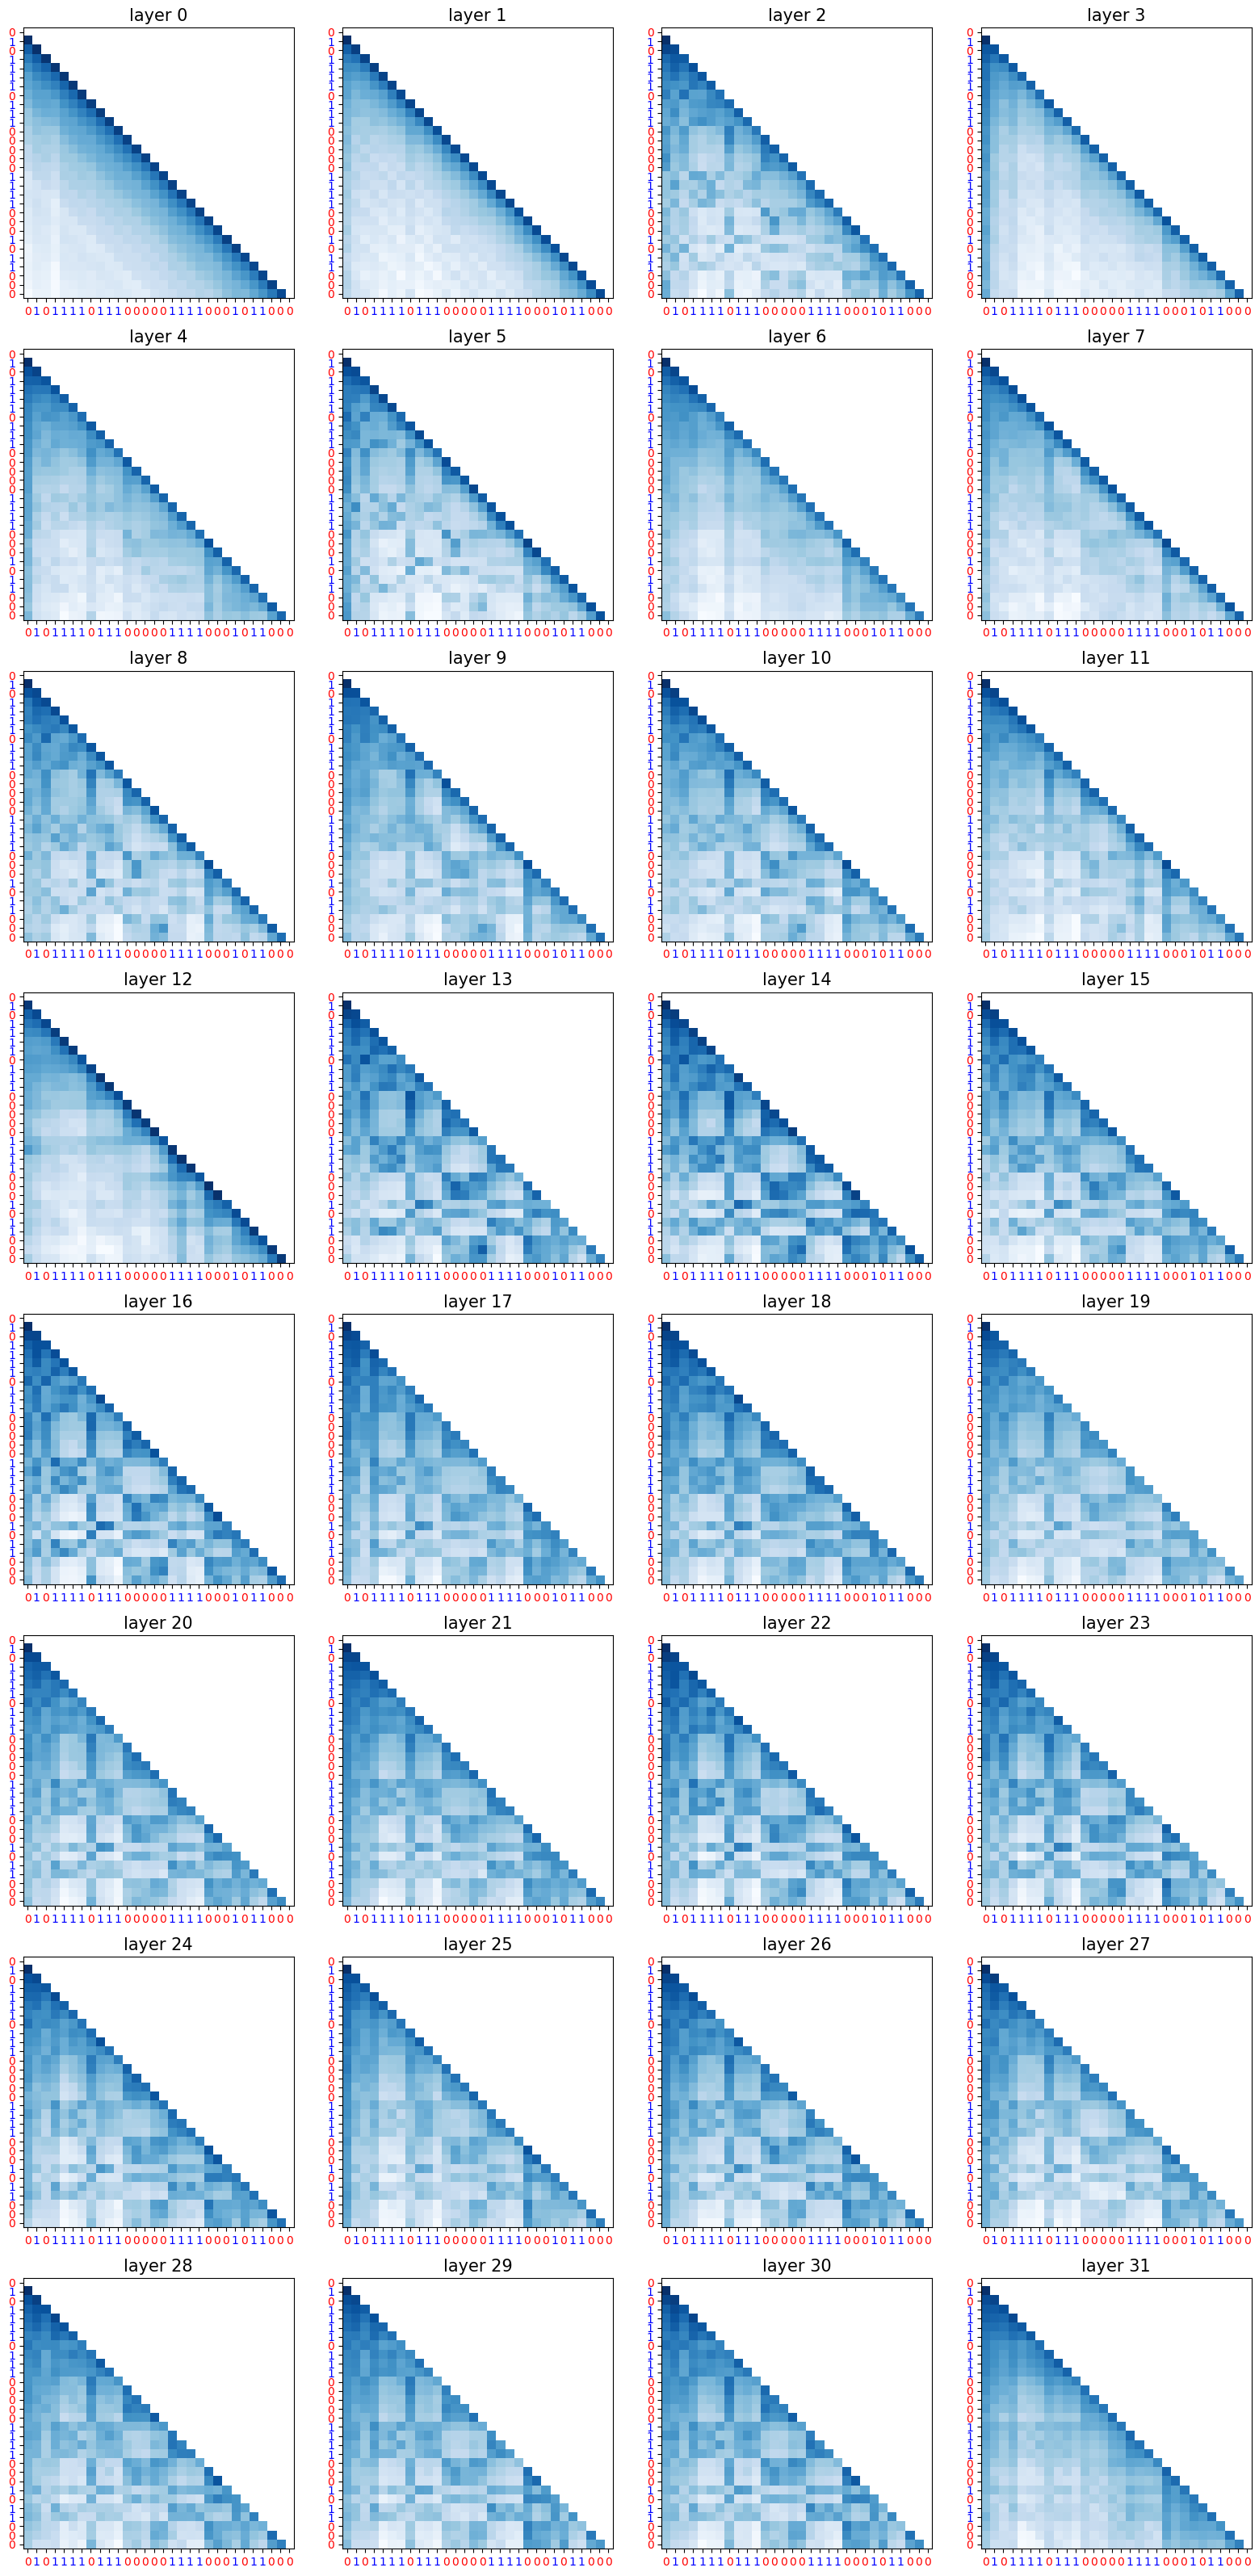

In [7]:
def color_ticklabels(ax, ticks):
    colors = ['red' if val == 0 else 'blue' for val in ticks]
    tick_labels = [str(val) for val in ticks]
    ax.set_xticks(range(len(ticks)), labels=ticks)
    for label, color in zip(ax.get_xticklabels(), colors):
        label.set_color(color)
    ax.set_yticks(range(len(ticks)), labels=ticks)
    for label, color in zip(ax.get_yticklabels(), colors):
        label.set_color(color)
        
fig, axes = plt.subplots(8, 4, figsize=(16, 32))
for k, layer in enumerate(range(32)):
    ax = axes[k//4, k%4]
    avg_attention = outputs['attentions'][layer].squeeze().mean(axis=0)
    W = torch.zeros((len(points), len(points)))
    for i in range(len(points)):
        for j in range(i + 1, len(points)): 
            s1,e1 = segments[i]
            s2,e2 = segments[j]
            weight = avg_attention[s2:e2+1, s1:e1+1].mean().item()
            W[j,i] = weight
    #W /= W.sum(axis=1, keepdim=True)
    ax.imshow(torch.log(W), cmap="Blues", interpolation="nearest")
    color_ticklabels(ax, gt)
    ax.set_title(f'layer {layer}',fontsize=15)

plt.tight_layout()
plt.show()